# Activate GPU and install fast.ai

# IMPORT REQUIRED MODELS

In [1]:
import fastai
from fastai import *
from fastai.text import * 
from fastai.text.models import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

import nltk
from nltk.corpus import stopwords
import re 
from bs4 import BeautifulSoup

from nltk.stem.snowball import SnowballStemmer

# Prepare data

In [2]:
# Not excluding stopwords as it performs better
stops={}

In [3]:
#PREPROCEESING THE TEXT

def text_preprocessing(text, language, minWordSize):
    
    # remove html
    text_html = BeautifulSoup(text,"html.parser" ).get_text()
    
    # remove non-letters
    text_non_letters = re.sub("[^a-zA-Z']", " ", text_html) 
        
    # convert to lower-case
    text_lower = text_non_letters.lower()
    
    # remove stop words
    text_no_stop_words = ' '
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '  
    
    # do stemming
    text_stemmer = ' '
    stemmer = SnowballStemmer(language)
    for w in text_no_stop_words.split():
        text_stemmer = text_stemmer + stemmer.stem(w) + ' '
         
    # remove short words
    text_no_short_words = ' '
    for w in text_stemmer.split(): 
        if len(w) >=minWordSize:
            text_no_short_words = text_no_short_words + w + ' '
    return text_lower

In [4]:
#load and prepare old data
df_reviews = pd.read_csv('Input_data/Old_data_reviews.csv',sep=',',quotechar='"' ) #contains the reviews from Facebook and Tripadvisor
df_cat_labels = pd.read_csv('Input_data/Old_data_categorisation_labels.csv',sep=',',quotechar='"') # contains the classlabels of the reviews
df_merged_data = pd.merge(df_cat_labels,df_reviews,how='left',left_on='review_id',right_on='id')

# Drop unnecessary columns
df_merged_data = df_merged_data.drop(['labeler_id', 'post_type', 'datetime_posted','likes', 'traveler_type',
                    'rating_food','rating_service', 'rating_environment', 'rating_value',
                     'reviewer_id','source_subject_id','id_x','review_id','id_y','source'],axis=1)

#select english reviews
def change_ratings(x):
    if x in [0, 1,2]:
        return -1
    elif x == 3:
        return 0
    else:
        return 1
olddata =  df_merged_data.loc[df_merged_data['language'] == 'en']
olddata['sentiment'] = olddata['rating'].apply(change_ratings)
reviews_old = olddata['text'].values
sentiment_old=olddata['sentiment'].values


In [5]:
#load and prepare new data
newdata=pd.read_csv('Input_data/New_data.csv')
# olddata = pd.read_csv("Input_data/Old_data_reviews.csv")
# newdata = pd.concat([newdata, olddata])
reviews_new= newdata['Text'].values
sentiment_new = newdata['Sentiment'].values

#Split category column 
newdata['category']=newdata['Categories'].apply(lambda x:x.split(';'))

def category_includer(data,string):    
    for i in range(len(data)):
        data.loc[i,string]=0
        column=list(data.loc[i,'category'])
        if string in column:
            data.loc[i,string]=1
    return data

newdata=category_includer(newdata,'experience')
newdata=category_includer(newdata,'service')
newdata=category_includer(newdata,'consistency')
newdata=category_includer(newdata,'value')
newdata=category_includer(newdata,'food')
newdata=category_includer(newdata,'convenience')

#dropping the two columns and filter only English
newdata=newdata.drop(['Categories','category'],axis=1)
newdata=newdata[newdata['Language']=="eng"]

In [6]:
# Preprocess

#reviews and sentiment as values
reviews_new= newdata['Text'].values
sentiment_new = newdata['Sentiment'].values

reviews = list(reviews_new) + list(reviews_old)
sentiment = list(sentiment_new) + list(sentiment_old)
#test train split
reviews_train, reviews_test, sentiment_train, sentiment_test = train_test_split(reviews_new, sentiment_new, test_size=0.2,random_state=0,stratify=sentiment_new)

#bag of words
language = 'english'
minWordLength = 2 # shorter words will be removed

for i in range(len(reviews_train)):
    reviews_train[i] = text_preprocessing(reviews_train[i], language, minWordLength)
for i in range(len(reviews_test)):
    reviews_test[i] = text_preprocessing(reviews_test[i], language, minWordLength)
        


/home/arul/anaconda3/envs/ath/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "https://www.valkyriestudios.be" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


# Create and train models

In [7]:
# Create language databunch
data_lm = TextLMDataBunch.from_df(train_df = pd.DataFrame({'text': reviews_train, 'labels': sentiment_train}), 
                                  valid_df = pd.DataFrame({'text': reviews_test, 'labels':sentiment_test}), 
                                  path = "",
                                 text_cols=0,
                                 label_cols=1)

# Create classifier databunch
data_clas = TextClasDataBunch.from_df(path = "", 
                                      train_df = pd.DataFrame({'text': reviews_train, 'labels': sentiment_train}),
                                      valid_df = pd.DataFrame({'text': reviews_test, 'labels': sentiment_test}), 
                                      vocab=data_lm.train_ds.vocab, bs=16,
                                     text_cols=0,
                                 label_cols=1)

In [8]:
# Load pre-trained (Wikipedia) model, which predicts the next word
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=True, drop_mult=0.3);

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


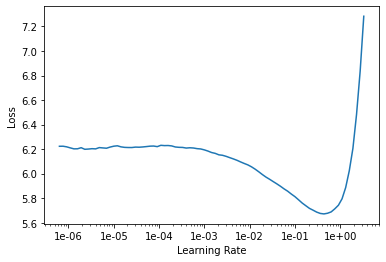

In [9]:
# Run learning rate finder and plot to find good learning rates
learn.lr_find()
learn.recorder.plot()

In [10]:
#Save in case want to restart from here
learn.save('fit_head')

In [11]:
#Load in case want to restart from here
learn.load('fit_head');

In [12]:
# Train the language model, which predicts the next word in a review, on the reviews data bunch.
# Train last layers for 1 epoch
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.301569,4.739258,0.175933,00:08


In [13]:
#Unfreeze and train for another epoch
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.688353,4.495827,0.206128,00:09
1,4.491562,4.298305,0.227455,00:09
2,4.287105,4.204474,0.238920,00:09
3,4.097982,4.180104,0.241944,00:09
4,3.958417,4.180285,0.242248,00:09


In [14]:
learn.save('fine_tuned')
learn.save_encoder('fine_tuned_enc')

In [15]:
learn.load('fine_tuned');
learn.load_encoder('fine_tuned_enc');

In [16]:
# Test what words it would predict
TEXT = "I had a"
N_WORDS = 40
N_SENTENCES = 2

In [17]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I had a coffee here in the late afternoon and it is a very lively place for a decent evening xxbos pre theatre theatre and i would n't recommend that xxbos i m a fan of the fashion restaurant and was very pleased
I had a lovely meal to celebrate my birthday with my sister the food was brilliant and the service was great i also do n't care too much about my husband 's bad experience xxbos we had the best spaghetti and even better


In [18]:
# Create classification model
learn = text_classifier_learner(data_clas, AWD_LSTM,drop_mult=0.2);

In [19]:
#Visualize the data
data_clas.show_batch()

text,target
xxbos i don t know where to start i have never before taken time out to write a review or complaint about an establishment but me and my partner s experience definitely xxunk one we pre booked our table over the phone for pm on saturday nd march being our anniversary we arrived on time but were asked to wait at the bar whilst our table was being prepared after,-1
xxbos please be aware bones in kids haddock goujons of the kids menu i visited middleton steak house in leicester on fathers day with my husband and kids a year old and month old we ordered my year old haddock goujons from little eaters menu half way through my daughters meal i noticed she was nt breathing her eyes where getting wider and wider and watering and she was getting,-1
xxbos xxunk i went with another person and the xxunk that came to us were this chicken has no xxunk this chicken is dead for no xxunk they are well situated in a lively place just renovated the inside is fine although i found it not clean the waiter had to clean our table after we were seated and the floor was not xxunk and waitress were nice and efficient,-1
xxbos i used to be a regular customer of middletons but sadly it has xxunk gone downhill the downstairs seating with the metal partition has clearly been designed to xxunk as many people as possible into the restaurant to the xxunk of the customer it 's more spacious in mcdonalds i even go to the xxunk of xxunk not to sit there when booking a table however my request was,-1
xxbos being a restaurant owner years i am very picky and as usual i will give you an honest review hope this helps my daughter lives very close and she invited us to dinner at this restaurant she just kept saying dad you will love the views and the food they do not take reservations so we went about and it was quiet and we sat outside highly recommend and,1


In [20]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3944 items)
x: TextList
xxbos we have been here several times we visited tonight for my sons first birthday and were treated like royalty the service is always great a big shout out to michael patti summer and also the lady who cleared up our plates sorry i forgot your name who are professional efficient and friendly food is always of high standard my husband loves the ribs i love the veggie burger and the chocolate brownie dessert is amazing portions are great too which is a bonus we are a family of four and my kids always enjoy their food from the children s menu the activity pack with the crayons are a good distraction,xxbos good food,xxbos great place to get a burger at lunch in xxunk the service can be a bit slow at times but other than that people are friendly here they have an ok selection of beer which is always great with a burger,xxbos we visited as a couple of friends on a monday night only other tables were taken and we 

In [21]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


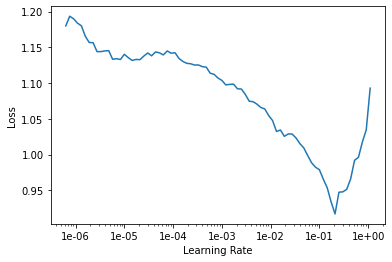

In [22]:
learn.recorder.plot()

In [23]:
# Train the classification model for one cycle
# learn.fit_one_cycle(1, 1e-1) #test
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
# train again after unfreezing part
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
# train again after unfreezing further
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
# train again after unfreezing full
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
#Get results for example
learn.predict("A Solid Good cafe - I say this, because i felt as though the service and the price could have been better. I almost felt ignored initially, but maybe that was because they were understaffed. I feel as though, with the price their, the service should have a bit more of a wow factor. But because of the high price and OK service I am rating a little lower. Coffee is great and the food is good too. I would go back!")

# Get accuracy and export

In [ ]:
# Get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis = 1)
accuracy_matrix=pd.crosstab(predictions, targets)


In [ ]:
# print confusion matrix
accuracy_matrix2=accuracy_matrix.copy()
accuracy_matrix2=accuracy_matrix2.rename(columns={0:-1,1:0,2:1})
accuracy_matrix2=accuracy_matrix2.rename(index={0: -1, 1:0, 2: 1})
accuracy_matrix2.T

In [ ]:
# Calculate different accuracy measures
precision_minus_1=accuracy_matrix[0][0]/accuracy_matrix.sum(1)[0]
precision_0 = accuracy_matrix[1][1]/accuracy_matrix.sum(1)[1]
precision_1 = accuracy_matrix[2][2]/accuracy_matrix.sum(1)[2]
precision=[precision_minus_1,precision_0,precision_1]
recall_minus_1 = accuracy_matrix[0][0]/accuracy_matrix.sum(0)[0]
recall_0 = accuracy_matrix[1][1]/accuracy_matrix.sum(0)[1]
recall_1 = accuracy_matrix[2][2]/accuracy_matrix.sum(0)[2]
recall=[recall_minus_1,recall_0,recall_1]
weighted_precision = (precision[0]*accuracy_matrix.sum(0)[0]+ precision[1]*accuracy_matrix.sum(0)[1]+ precision[2]*accuracy_matrix.sum(0)[2])/sum(accuracy_matrix.sum(0))
weighted_recall = (recall[0]*accuracy_matrix.sum(1)[0]+ recall[1]*accuracy_matrix.sum(1)[1]+ recall[2]*accuracy_matrix.sum(1)[2])/sum(accuracy_matrix.sum(1))

In [ ]:
print('The weighted average precision is %.2f'%(weighted_precision))


In [ ]:
# Export and download the file
learn.export('train_all_test_all_sentiment_bestmodel_ulmfit.pkl');
# files.download('train_all_test_all_sentiment_bestmodel_ulmfit.pkl');

In [ ]:
#upload the file to google drive then get the path of the file
path='/models'

In [ ]:
#load the file 
l = load_learner(path, 'export.pkl')

In [ ]:
# predicted probability of -1, 0, 1
pred =learn.predict("High quality food,well served,few dishes,clean,young,very friendly. Has a part of a large pavement's corner with wood tables and benches.Wonderful place to have breakfast.")

In [ ]:
str(pred[0])

In [ ]:
newdata['pred'] = newdata['Text'].apply(lambda txt: str(learn.predict(txt)[0]))

In [ ]:
accuracy_matrix = pd.crosstab(newdata.pred,newdata.Sentiment)
accuracy_matrix.T

In [ ]:
# Calculate different accuracy measures
precision_minus_1=accuracy_matrix[-1][-1]/accuracy_matrix.sum(1)[-1]
precision_0 = accuracy_matrix[0][0]/accuracy_matrix.sum(1)[0]
precision_1 = accuracy_matrix[1][1]/accuracy_matrix.sum(1)[1]
precision=[precision_minus_1,precision_0,precision_1]
recall_minus_1 = accuracy_matrix[-1][-1]/accuracy_matrix.sum(0)[-1]
recall_0 = accuracy_matrix[0][0]/accuracy_matrix.sum(0)[0]
recall_1 = accuracy_matrix[1][1]/accuracy_matrix.sum(0)[1]
recall=[recall_minus_1,recall_0,recall_1]
weighted_precision = (precision[-1]*accuracy_matrix.sum(0)[-1]+ precision[0]*accuracy_matrix.sum(0)[0]+ precision[1]*accuracy_matrix.sum(0)[1])/sum(accuracy_matrix.sum(0))
weighted_recall = (recall[-1]*accuracy_matrix.sum(1)[-1]+ recall[0]*accuracy_matrix.sum(1)[0]+ recall[1]*accuracy_matrix.sum(1)[1])/sum(accuracy_matrix.sum(1))
print('The weighted average precision is %.2f'%(weighted_precision))